# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Thu Apr  7 02:34:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   57C    P2    65W / 275W |   7268MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download and import required packages

In [2]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [3]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [4]:
import sys
import pdb
import pprint
import logging
import os
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [5]:
seed = 10942178
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

raw.en
raw.zh
test/
test/test.zh
test/test.en


## Language

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [18]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/transformer-bt",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-07 02:34:59 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-07 02:34:59 | INFO | fairseq.utils | rank   0: capabilities =  6.1  ; total memory = 10.913 GB ; name = NVIDIA GeForce GTX 1080 Ti              
2022-04-07 02:34:59 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-07 02:34:59 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types
2022-04-07 02:34:59 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-07 02:34:59 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-07 02:34:59 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-04-07 02:34:59 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-04-07 02:34:59 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2022-04-07 02:34:59 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-04-07 02:34:59 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-04-07 02:34:59 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  53, 3134, 3107,   34,  408, 1223, 3895,  670,    9, 1038,  498,  148,
        1689,  364,  129, 1050, 1103,   34,  408,  158,  607, 3268,  306,    9,
        1105,    2]),
 'target': tensor([  35,   22,  440,   27,    5,  850,  261,  172,    6,   29,  800,    6,
         184,  164,   99, 1178,  374,  804,  257,   41,    5,  313,  868,   42,
          27,   61, 1836,   18,  184, 1147, 1404,   21,    6,    6,  320,    7,
           2])}
'Source: 我們培植了一些果蠅它們的腦部被隨機地安置了一些可以光驅動的細胞'
('Target: so we bred flies whose brains were more or less randomly peppered '
 'with cells that were light addressable .')


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [24]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-07 02:35:00 | WARNING | fairseq.tasks.fairseq_task | 2,565 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1811, 3245, 3729, 1898, 732, 226, 3630, 2905, 2594, 196]


{'id': tensor([2001, 3666]),
 'nsentences': 2,
 'ntokens': 15,
 'net_input': {'src_tokens': tensor([[   1,    5,  299, 1257,  843,  611,  413,    2],
          [   1,   53,  968,  407,  177,  362,   33,    2]]),
  'src_lengths': tensor([7, 7]),
  'prev_output_tokens': tensor([[   2, 1166,  812,  542,  519,  538,    7,    1],
          [   2,  151,  741,   22,  657,  718,   18,   33]])},
 'target': tensor([[1166,  812,  542,  519,  538,    7,    2,    1],
         [ 151,  741,   22,  657,  718,   18,   33,    2]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [25]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [26]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [27]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [28]:
arch_args = Namespace(
    encoder_embed_dim=480,
    encoder_ffn_embed_dim=2048,
    encoder_layers=5,
    decoder_embed_dim=480,
    decoder_ffn_embed_dim=2048,
    decoder_layers=5,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=12
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=12
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [29]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [30]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-07 02:35:01 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 480, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=480, out_features=480, bias=True)
          (v_proj): Linear(in_features=480, out_features=480, bias=True)
          (q_proj): Linear(in_features=480, out_features=480, bias=True)
          (out_proj): Linear(in_features=480, out_features=480, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=480, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=480, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [31]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [32]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    return d_model**(-0.5) * min(step_num ** (-0.5), step_num * warmup_step ** (-1.5))

In [33]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

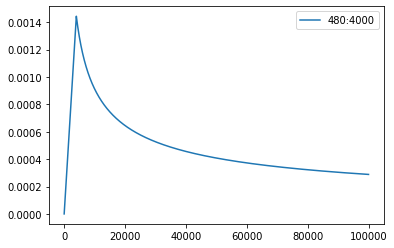

In [34]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [35]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [36]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [37]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [38]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [39]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [40]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-07 02:35:04 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-07 02:35:04 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-07 02:35:04 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-07 02:35:04 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-07 02:35:04 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-07 02:35:04 | INFO | hw5.seq2seq | num. model params: 41,237,120 (num. trained: 41,237,120)
2022-04-07 02:35:04 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [41]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-07 02:35:05 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326738]
2022-04-07 02:35:05 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer-bt/checkpoint_last.pt!


train epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 02:45:15 | INFO | hw5.seq2seq | training loss: 5.6764
2022-04-07 02:45:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

/home/weiweichi/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/weiweichi/.local/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


2022-04-07 02:45:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 02:45:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 02:45:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 02:45:51 | INFO | hw5.seq2seq | example source: 艾曼達 , 能否請您分享您如何失去手臂的 ?
2022-04-07 02:45:51 | INFO | hw5.seq2seq | example hypothesis: johhn , how can you get to tell you how do you get your hand ?
2022-04-07 02:45:51 | INFO | hw5.seq2seq | example reference: so amanda , would you please tell us how you lost your arm ?
2022-04-07 02:45:51 | INFO | hw5.seq2seq | validation loss:	4.3532
2022-04-07 02:45:51 | INFO | hw5.seq2seq | BLEU = 3.04 27.3/5.4/1.5/0.4 (BP = 0.979 ratio = 0.979 hyp_len = 74559 ref_len = 76142)
2022-04-07 02:45:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/

train epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 02:56:01 | INFO | hw5.seq2seq | training loss: 3.9279
2022-04-07 02:56:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 02:56:33 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 02:56:33 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 02:56:33 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 02:56:33 | INFO | hw5.seq2seq | example source: 在未來兩年 , 我的工作是設計一個總體計畫並於十年內執行本計劃-當然 , 這需要眾人攜手合作 。
2022-04-07 02:56:33 | INFO | hw5.seq2seq | example hypothesis: in two years , my job is designed to be a summer , and of course , it's a requirement project , and of course , it's a required to work .
2022-04-07 02:56:33 | INFO | hw5.seq2seq | example reference: that is my job for the next two years , to design an entire master plan , and then for the next 10 years to implement it of course , with so many other people .
2022-04-07 02:56:33 | INFO | hw5.seq2seq | validation loss:	3.4911
2022-04-07 02:56:33 

train epoch 3:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 03:06:45 | INFO | hw5.seq2seq | training loss: 3.3538
2022-04-07 03:06:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 03:07:11 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 03:07:11 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 03:07:11 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 03:07:11 | INFO | hw5.seq2seq | example source: 如果我們能夠改變這個動力 , 首先 , 創造人口密度更高更適合居住的城市...
2022-04-07 03:07:11 | INFO | hw5.seq2seq | example hypothesis: if we can change this , first of all , create density , create dense cities .
2022-04-07 03:07:11 | INFO | hw5.seq2seq | example reference: if we can change the dynamic , by first of all creating cities that are denser and more livable . . .
2022-04-07 03:07:11 | INFO | hw5.seq2seq | validation loss:	3.1678
2022-04-07 03:07:11 | INFO | hw5.seq2seq | BLEU = 10.75 52.6/21.1/10.0/4.9 (BP = 0.703 ratio = 0.739 hyp_len = 56287 ref_len = 76142)
2022-04-07 03:

train epoch 4:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 03:17:25 | INFO | hw5.seq2seq | training loss: 3.0960
2022-04-07 03:17:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 03:17:53 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 03:17:53 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 03:17:53 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 03:17:53 | INFO | hw5.seq2seq | example source: 他將與我同行 ,
2022-04-07 03:17:53 | INFO | hw5.seq2seq | example hypothesis: he's going to work with me .
2022-04-07 03:17:53 | INFO | hw5.seq2seq | example reference: he is coming with me .
2022-04-07 03:17:53 | INFO | hw5.seq2seq | validation loss:	3.0139
2022-04-07 03:17:53 | INFO | hw5.seq2seq | BLEU = 13.43 50.6/21.4/10.5/5.4 (BP = 0.853 ratio = 0.863 hyp_len = 65703 ref_len = 76142)
2022-04-07 03:17:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint4.pt
2022-04-07 03:17:56 | INFO | hw5.seq2

train epoch 5:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 03:28:06 | INFO | hw5.seq2seq | training loss: 2.9631
2022-04-07 03:28:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 03:28:37 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 03:28:37 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 03:28:37 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 03:28:37 | INFO | hw5.seq2seq | example source: 這叫快速通關走道或vip票
2022-04-07 03:28:37 | INFO | hw5.seq2seq | example hypothesis: this is called quick traffic or vip .
2022-04-07 03:28:37 | INFO | hw5.seq2seq | example reference: they call them fast track or vip tickets .
2022-04-07 03:28:37 | INFO | hw5.seq2seq | validation loss:	2.9447
2022-04-07 03:28:37 | INFO | hw5.seq2seq | BLEU = 15.04 48.6/21.0/10.4/5.4 (BP = 0.972 ratio = 0.972 hyp_len = 74048 ref_len = 76142)
2022-04-07 03:28:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint5.pt
202

train epoch 6:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 03:38:49 | INFO | hw5.seq2seq | training loss: 2.8529
2022-04-07 03:38:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 03:39:19 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 03:39:19 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 03:39:19 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 03:39:19 | INFO | hw5.seq2seq | example source: 可能我們會想要把它用在某些結構上之類的 。
2022-04-07 03:39:19 | INFO | hw5.seq2seq | example hypothesis: maybe we're going to want to use it to some structures or something like that .
2022-04-07 03:39:19 | INFO | hw5.seq2seq | example reference: probably we're going to want it for some structures , and so on .
2022-04-07 03:39:19 | INFO | hw5.seq2seq | validation loss:	2.8229
2022-04-07 03:39:19 | INFO | hw5.seq2seq | BLEU = 16.10 52.0/23.2/12.0/6.5 (BP = 0.921 ratio = 0.924 hyp_len = 70330 ref_len = 76142)
2022-04-07 03:39:20 | INFO | hw5.seq2seq | saved epoch checkpoint:

train epoch 7:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 03:49:30 | INFO | hw5.seq2seq | training loss: 2.7307
2022-04-07 03:49:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 03:50:01 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 03:50:01 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 03:50:01 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 03:50:01 | INFO | hw5.seq2seq | example source: 最後還有支付能力的問題
2022-04-07 03:50:01 | INFO | hw5.seq2seq | example hypothesis: and finally , there's a problem of payment .
2022-04-07 03:50:01 | INFO | hw5.seq2seq | example reference: and then there's finally there's the affordability question .
2022-04-07 03:50:01 | INFO | hw5.seq2seq | validation loss:	2.7654
2022-04-07 03:50:01 | INFO | hw5.seq2seq | BLEU = 16.85 50.0/22.6/11.7/6.3 (BP = 0.990 ratio = 0.990 hyp_len = 75393 ref_len = 76142)
2022-04-07 03:50:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transform

train epoch 8:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 04:00:12 | INFO | hw5.seq2seq | training loss: 2.6447
2022-04-07 04:00:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 04:00:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 04:00:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 04:00:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 04:00:42 | INFO | hw5.seq2seq | example source: 這相當於每年從海裡撈出全體中國人的重量 。
2022-04-07 04:00:42 | INFO | hw5.seq2seq | example hypothesis: that's the equivalent of the weight of the chinese from the ocean every year .
2022-04-07 04:00:42 | INFO | hw5.seq2seq | example reference: that's the equivalent of the human weight of china taken out of the sea every year .
2022-04-07 04:00:42 | INFO | hw5.seq2seq | validation loss:	2.7043
2022-04-07 04:00:42 | INFO | hw5.seq2seq | BLEU = 18.17 53.5/25.1/13.5/7.5 (BP = 0.946 ratio = 0.948 hyp_len = 72149 ref_len = 76142)
2022-04-07 04:00:44 | INFO | hw5.seq2seq | saved

train epoch 9:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 04:10:56 | INFO | hw5.seq2seq | training loss: 2.5734
2022-04-07 04:10:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 04:11:23 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 04:11:23 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 04:11:23 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 04:11:23 | INFO | hw5.seq2seq | example source: 謝謝 。
2022-04-07 04:11:23 | INFO | hw5.seq2seq | example hypothesis: thank you .
2022-04-07 04:11:23 | INFO | hw5.seq2seq | example reference: thank you .
2022-04-07 04:11:23 | INFO | hw5.seq2seq | validation loss:	2.7009
2022-04-07 04:11:23 | INFO | hw5.seq2seq | BLEU = 17.14 57.8/27.7/15.1/8.6 (BP = 0.803 ratio = 0.820 hyp_len = 62435 ref_len = 76142)
2022-04-07 04:11:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint9.pt
2022-04-07 04:11:25 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 04:21:33 | INFO | hw5.seq2seq | training loss: 2.5165
2022-04-07 04:21:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 04:22:02 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 04:22:02 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 04:22:02 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 04:22:02 | INFO | hw5.seq2seq | example source: 合作社的成員是自我選拔 。
2022-04-07 04:22:02 | INFO | hw5.seq2seq | example hypothesis: the members of the collaborators are selfreplication .
2022-04-07 04:22:02 | INFO | hw5.seq2seq | example reference: the slime mould collective membership is selfselecting .
2022-04-07 04:22:02 | INFO | hw5.seq2seq | validation loss:	2.6598
2022-04-07 04:22:02 | INFO | hw5.seq2seq | BLEU = 18.97 56.1/27.2/15.0/8.6 (BP = 0.900 ratio = 0.905 hyp_len = 68911 ref_len = 76142)
2022-04-07 04:22:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/tr

train epoch 11:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 04:32:13 | INFO | hw5.seq2seq | training loss: 2.4681
2022-04-07 04:32:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 04:32:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 04:32:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 04:32:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 04:32:42 | INFO | hw5.seq2seq | example source: 我製作了實體版的 「 笨鳥先飛 」 , 而它不會從應用程式商店下架 。
2022-04-07 04:32:42 | INFO | hw5.seq2seq | example hypothesis: i made a physical version of " birds fly first , " and it doesn't fight from the app store .
2022-04-07 04:32:42 | INFO | hw5.seq2seq | example reference: i made a physical version of flappy bird that could never be taken off the app store .
2022-04-07 04:32:42 | INFO | hw5.seq2seq | validation loss:	2.6403
2022-04-07 04:32:42 | INFO | hw5.seq2seq | BLEU = 19.56 55.5/27.0/15.0/8.7 (BP = 0.929 ratio = 0.931 hyp_len = 70891 ref_len = 76142)
2022-04-07 04:32:4

train epoch 12:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 04:42:53 | INFO | hw5.seq2seq | training loss: 2.4261
2022-04-07 04:42:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 04:43:22 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 04:43:22 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 04:43:22 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 04:43:22 | INFO | hw5.seq2seq | example source: 那樣的特質導致一種網路架構 , 這種架構前所未有 , 其後的其它數位網路也無法比擬 。
2022-04-07 04:43:22 | INFO | hw5.seq2seq | example hypothesis: that trait has led to a network framework that has never existed before , and the rest of the digital network is impossible to simulate .
2022-04-07 04:43:22 | INFO | hw5.seq2seq | example reference: that ethos led to a network architecture , a structure that was unlike other digital networks then or since .
2022-04-07 04:43:22 | INFO | hw5.seq2seq | validation loss:	2.6320
2022-04-07 04:43:22 | INFO | hw5.seq2seq | BLEU = 19.82 56.2/27.6/15.4/9.0 (

train epoch 13:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 04:53:33 | INFO | hw5.seq2seq | training loss: 2.3894
2022-04-07 04:53:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 04:54:03 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 04:54:03 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 04:54:03 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 04:54:03 | INFO | hw5.seq2seq | example source: 我是個運動員 。 那是我唯一懂得的事 , 也是唯一做過的事 。
2022-04-07 04:54:03 | INFO | hw5.seq2seq | example hypothesis: i'm an athlete . that's the only thing i know , and the only thing i've ever done .
2022-04-07 04:54:03 | INFO | hw5.seq2seq | example reference: i was an athlete . that's all i knew . that's all i'd done .
2022-04-07 04:54:03 | INFO | hw5.seq2seq | validation loss:	2.6254
2022-04-07 04:54:03 | INFO | hw5.seq2seq | BLEU = 19.99 55.7/27.3/15.3/8.9 (BP = 0.937 ratio = 0.939 hyp_len = 71486 ref_len = 76142)
2022-04-07 04:54:05 | INFO | hw5.seq2seq | saved epoch ch

train epoch 14:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 05:04:16 | INFO | hw5.seq2seq | training loss: 2.3555
2022-04-07 05:04:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 05:04:45 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 05:04:45 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 05:04:45 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 05:04:45 | INFO | hw5.seq2seq | example source: 我可以想像一個未來 , 在這個未來中 , 我們會很高興看到學齡前兒童與螢幕互動 。
2022-04-07 05:04:45 | INFO | hw5.seq2seq | example hypothesis: i can imagine a future where we're going to be happy to see preschool children interacting with screens .
2022-04-07 05:04:45 | INFO | hw5.seq2seq | example reference: i can envision a future where we would be excited to see a preschooler interacting with a screen .
2022-04-07 05:04:45 | INFO | hw5.seq2seq | validation loss:	2.6300
2022-04-07 05:04:45 | INFO | hw5.seq2seq | BLEU = 19.90 56.1/27.6/15.4/8.9 (BP = 0.926 ratio = 0.929 hyp_len = 70717 ref_

train epoch 15:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 05:14:56 | INFO | hw5.seq2seq | training loss: 2.3266
2022-04-07 05:14:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 05:15:26 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 05:15:26 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 05:15:26 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 05:15:26 | INFO | hw5.seq2seq | example source: 裡面沒有鋪設好的道路 , 也沒有水泥的停車位地基 。 在拖車停車位之間也沒有圍籬 。
2022-04-07 05:15:26 | INFO | hw5.seq2seq | example hypothesis: there's no roads , there's no cement parking ground , there's no fence between the trailer park .
2022-04-07 05:15:26 | INFO | hw5.seq2seq | example reference: it didn't have any paved roads in it , it didn't have the concrete slabs , it didn't have fencing to portion off your trailer slot from other trailer slots .
2022-04-07 05:15:26 | INFO | hw5.seq2seq | validation loss:	2.6220
2022-04-07 05:15:26 | INFO | hw5.seq2seq | BLEU = 19.62 56.2/27.4/15.

train epoch 16:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 05:25:37 | INFO | hw5.seq2seq | training loss: 2.2992
2022-04-07 05:25:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 05:26:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 05:26:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 05:26:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 05:26:06 | INFO | hw5.seq2seq | example source: 嬰兒不會説話 , 對吧 ? 」
2022-04-07 05:26:06 | INFO | hw5.seq2seq | example hypothesis: babies don't talk , right ? "
2022-04-07 05:26:06 | INFO | hw5.seq2seq | example reference: infants can't talk , right ? "
2022-04-07 05:26:06 | INFO | hw5.seq2seq | validation loss:	2.6248
2022-04-07 05:26:06 | INFO | hw5.seq2seq | BLEU = 19.93 56.3/27.7/15.5/9.0 (BP = 0.923 ratio = 0.926 hyp_len = 70492 ref_len = 76142)
2022-04-07 05:26:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint16.pt
2022-04-07 05:26:08 

train epoch 17:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 05:36:18 | INFO | hw5.seq2seq | training loss: 2.2733
2022-04-07 05:36:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 05:36:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 05:36:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 05:36:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 05:36:48 | INFO | hw5.seq2seq | example source: 而身為老師、妻子這自然也是我每天都面對的問題
2022-04-07 05:36:48 | INFO | hw5.seq2seq | example hypothesis: and as a teacher , as a wife , that's what i'm dealing with every day .
2022-04-07 05:36:48 | INFO | hw5.seq2seq | example reference: so as a teacher and as a spouse , this is , of course , a problem i confront every day .
2022-04-07 05:36:48 | INFO | hw5.seq2seq | validation loss:	2.6269
2022-04-07 05:36:48 | INFO | hw5.seq2seq | BLEU = 19.85 54.8/26.7/14.8/8.6 (BP = 0.956 ratio = 0.957 hyp_len = 72850 ref_len = 76142)
2022-04-07 05:36:50 | INFO | hw5.seq2seq | saved e

train epoch 18:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 05:46:57 | INFO | hw5.seq2seq | training loss: 2.2517
2022-04-07 05:46:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 05:47:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 05:47:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 05:47:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 05:47:27 | INFO | hw5.seq2seq | example source: 後來我們真的這樣做了 , 那是好事 。
2022-04-07 05:47:27 | INFO | hw5.seq2seq | example hypothesis: and then we did , and that's a good thing .
2022-04-07 05:47:27 | INFO | hw5.seq2seq | example reference: so we did that . it was a good thing .
2022-04-07 05:47:27 | INFO | hw5.seq2seq | validation loss:	2.6264
2022-04-07 05:47:27 | INFO | hw5.seq2seq | BLEU = 19.93 55.7/27.4/15.3/9.0 (BP = 0.932 ratio = 0.934 hyp_len = 71118 ref_len = 76142)
2022-04-07 05:47:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint

train epoch 19:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 05:57:37 | INFO | hw5.seq2seq | training loss: 2.2312
2022-04-07 05:57:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 05:58:07 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 05:58:07 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 05:58:07 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 05:58:07 | INFO | hw5.seq2seq | example source: 他們選擇昂貴的檢測他們選擇為體弱的老人動手術
2022-04-07 05:58:07 | INFO | hw5.seq2seq | example hypothesis: they chose expensive tests , and they chose to operate on weak old people .
2022-04-07 05:58:07 | INFO | hw5.seq2seq | example reference: you choose an expensive lab test , you choose to operate on an old and frail patient .
2022-04-07 05:58:07 | INFO | hw5.seq2seq | validation loss:	2.6262
2022-04-07 05:58:07 | INFO | hw5.seq2seq | BLEU = 20.28 55.2/27.1/15.2/8.9 (BP = 0.957 ratio = 0.958 hyp_len = 72907 ref_len = 76142)
2022-04-07 05:58:09 | INFO | hw5.seq2seq | saved

train epoch 20:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 06:08:19 | INFO | hw5.seq2seq | training loss: 2.2113
2022-04-07 06:08:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 06:08:49 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 06:08:49 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 06:08:49 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 06:08:49 | INFO | hw5.seq2seq | example source: 我是說 , 這些事都在他眼下發生
2022-04-07 06:08:49 | INFO | hw5.seq2seq | example hypothesis: i mean , all of this is happening under his eyes .
2022-04-07 06:08:49 | INFO | hw5.seq2seq | example reference: i mean after all , this whole business happened on his watch .
2022-04-07 06:08:49 | INFO | hw5.seq2seq | validation loss:	2.6398
2022-04-07 06:08:49 | INFO | hw5.seq2seq | BLEU = 19.72 55.8/27.3/15.2/8.8 (BP = 0.930 ratio = 0.932 hyp_len = 70982 ref_len = 76142)
2022-04-07 06:08:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoin

train epoch 21:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 06:19:00 | INFO | hw5.seq2seq | training loss: 2.1931
2022-04-07 06:19:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 06:19:29 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 06:19:29 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 06:19:29 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 06:19:29 | INFO | hw5.seq2seq | example source: 有50%的車禍發生在十字路口
2022-04-07 06:19:29 | INFO | hw5.seq2seq | example hypothesis: fifty percent of the crashes occur in crossroads .
2022-04-07 06:19:29 | INFO | hw5.seq2seq | example reference: fifty percent of crashes happen at intersections .
2022-04-07 06:19:29 | INFO | hw5.seq2seq | validation loss:	2.6448
2022-04-07 06:19:29 | INFO | hw5.seq2seq | BLEU = 19.83 56.2/27.5/15.3/8.8 (BP = 0.928 ratio = 0.931 hyp_len = 70856 ref_len = 76142)
2022-04-07 06:19:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer

train epoch 22:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 06:29:38 | INFO | hw5.seq2seq | training loss: 2.1752
2022-04-07 06:29:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 06:30:08 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 06:30:08 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 06:30:08 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 06:30:08 | INFO | hw5.seq2seq | example source: 我們要問自己這些問題 , 不論這是多麼的令人不快 。
2022-04-07 06:30:08 | INFO | hw5.seq2seq | example hypothesis: we have to ask ourselves these questions , no matter how unpleasant it is .
2022-04-07 06:30:08 | INFO | hw5.seq2seq | example reference: we have to ask ourselves these questions , however unpalatable .
2022-04-07 06:30:08 | INFO | hw5.seq2seq | validation loss:	2.6508
2022-04-07 06:30:08 | INFO | hw5.seq2seq | BLEU = 19.63 56.5/27.6/15.4/9.0 (BP = 0.911 ratio = 0.915 hyp_len = 69653 ref_len = 76142)
2022-04-07 06:30:09 | INFO | hw5.seq2seq | saved epoch checkpoint:

train epoch 23:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 06:40:17 | INFO | hw5.seq2seq | training loss: 2.1592
2022-04-07 06:40:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 06:40:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 06:40:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 06:40:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 06:40:47 | INFO | hw5.seq2seq | example source: 有些會太靠近恆星 , 會被烤熟 , 有些則太遙遠 , 會被冰凍 。
2022-04-07 06:40:47 | INFO | hw5.seq2seq | example hypothesis: some of them are too close to stars that they'll be took , and some of them too far will be frozen .
2022-04-07 06:40:47 | INFO | hw5.seq2seq | example reference: some will be too close to a star and they'll fry , some will be too far away and they'll freeze .
2022-04-07 06:40:47 | INFO | hw5.seq2seq | validation loss:	2.6605
2022-04-07 06:40:47 | INFO | hw5.seq2seq | BLEU = 19.66 56.3/27.5/15.3/8.8 (BP = 0.919 ratio = 0.923 hyp_len = 70245 ref_len = 76142)
2

train epoch 24:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 06:50:57 | INFO | hw5.seq2seq | training loss: 2.1452
2022-04-07 06:50:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 06:51:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 06:51:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 06:51:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 06:51:27 | INFO | hw5.seq2seq | example source: 我認為大多數的人都不想死但我認為大多數的人都想要控制自己的死亡過程
2022-04-07 06:51:27 | INFO | hw5.seq2seq | example hypothesis: i think most people don't want to die , but i think most people want to control their mortality .
2022-04-07 06:51:27 | INFO | hw5.seq2seq | example reference: i think most people don't want to be dead , but i do think most people want to have some control over how their dying process proceeds .
2022-04-07 06:51:27 | INFO | hw5.seq2seq | validation loss:	2.6580
2022-04-07 06:51:27 | INFO | hw5.seq2seq | BLEU = 19.99 56.2/27.6/15.5/9.1 (BP = 0.924 ratio = 0.92

train epoch 25:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 07:01:38 | INFO | hw5.seq2seq | training loss: 2.1303
2022-04-07 07:01:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:02:07 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:02:07 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:02:07 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:02:07 | INFO | hw5.seq2seq | example source: 目前我們正在土耳其建造一座更長一點的橋 , 我們也設計了義大利的墨西拿海峽大橋 , 正在等待開始動工的日子 , 天知道是何時 。
2022-04-07 07:02:07 | INFO | hw5.seq2seq | example hypothesis: we're currently building a longer , longer bridge in turkey , and we're designing a canyon bridge in mexico , and we're waiting for the start of day to know when .
2022-04-07 07:02:07 | INFO | hw5.seq2seq | example reference: we're currently working on one in turkey which is a bit longer , and we've designed the messina bridge in italy , which is just waiting to get started with construction one day , who knows when .
2022-04-07

train epoch 26:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 07:12:17 | INFO | hw5.seq2seq | training loss: 2.1175
2022-04-07 07:12:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:12:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:12:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:12:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:12:46 | INFO | hw5.seq2seq | example source: 國王在如雷掌聲中接過皇冠、權仗亨利·克里斯托夫登上離地20米的寶座
2022-04-07 07:12:46 | INFO | hw5.seq2seq | example hypothesis: the king received the crown , henry christopher in the arms of the crown , 20 meters .
2022-04-07 07:12:46 | INFO | hw5.seq2seq | example reference: after receiving his ornate crown and scepter , henry christophe ascended his throne , towering 20 meters in the air .
2022-04-07 07:12:46 | INFO | hw5.seq2seq | validation loss:	2.6730
2022-04-07 07:12:46 | INFO | hw5.seq2seq | BLEU = 19.81 56.4/27.6/15.4/8.9 (BP = 0.922 ratio = 0.925 hyp_len = 70397 ref_len = 76

train epoch 27:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 07:22:57 | INFO | hw5.seq2seq | training loss: 2.1033
2022-04-07 07:22:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:23:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:23:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:23:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:23:27 | INFO | hw5.seq2seq | example source: 他們不知道那有多荒謬 , 而我知道 。
2022-04-07 07:23:27 | INFO | hw5.seq2seq | example hypothesis: they didn't know how ridiculous it was , and i knew .
2022-04-07 07:23:27 | INFO | hw5.seq2seq | example reference: now , they don't know how ridiculous that is , but i do .
2022-04-07 07:23:27 | INFO | hw5.seq2seq | validation loss:	2.6829
2022-04-07 07:23:27 | INFO | hw5.seq2seq | BLEU = 19.56 56.3/27.4/15.3/8.9 (BP = 0.914 ratio = 0.917 hyp_len = 69843 ref_len = 76142)
2022-04-07 07:23:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoi

train epoch 28:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 07:33:36 | INFO | hw5.seq2seq | training loss: 2.0921
2022-04-07 07:33:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:34:05 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:34:05 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:34:05 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:34:05 | INFO | hw5.seq2seq | example source: 這概念就是大家所知的 「 熱輻射 」 。
2022-04-07 07:34:05 | INFO | hw5.seq2seq | example hypothesis: this is the idea that you know , thermal radiation .
2022-04-07 07:34:05 | INFO | hw5.seq2seq | example reference: this is a concept known as thermal radiation .
2022-04-07 07:34:05 | INFO | hw5.seq2seq | validation loss:	2.6763
2022-04-07 07:34:05 | INFO | hw5.seq2seq | BLEU = 19.69 55.8/27.2/15.1/8.7 (BP = 0.931 ratio = 0.934 hyp_len = 71083 ref_len = 76142)
2022-04-07 07:34:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transfo

train epoch 29:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 07:44:15 | INFO | hw5.seq2seq | training loss: 2.0801
2022-04-07 07:44:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:44:44 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:44:44 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:44:44 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:44:44 | INFO | hw5.seq2seq | example source: 老實說 , 我們其實可以提前完成這個企畫 , 但我想我們因為這些喝茶休憩時間多做了三周 。
2022-04-07 07:44:44 | INFO | hw5.seq2seq | example hypothesis: and honestly , we can actually do this project ahead of time , but i think we've taken three more time open for this recession .
2022-04-07 07:44:44 | INFO | hw5.seq2seq | example reference: and to be honest with you , we could have finished earlier , but i think it took us three weeks because of all those tea breaks .
2022-04-07 07:44:44 | INFO | hw5.seq2seq | validation loss:	2.6894
2022-04-07 07:44:44 | INFO | hw5.seq2seq | BLEU = 19.82 56.2/27

train epoch 30:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-07 07:54:55 | INFO | hw5.seq2seq | training loss: 2.0702
2022-04-07 07:54:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:55:24 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:55:24 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:55:24 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:55:24 | INFO | hw5.seq2seq | example source: 所以這是個好消息
2022-04-07 07:55:24 | INFO | hw5.seq2seq | example hypothesis: so that's the good news .
2022-04-07 07:55:24 | INFO | hw5.seq2seq | example reference: so that was good news .
2022-04-07 07:55:24 | INFO | hw5.seq2seq | validation loss:	2.6990
2022-04-07 07:55:24 | INFO | hw5.seq2seq | BLEU = 19.59 55.7/27.0/15.0/8.7 (BP = 0.929 ratio = 0.931 hyp_len = 70916 ref_len = 76142)
2022-04-07 07:55:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint30.pt
2022-04-07 07:55:26 | INFO | hw5.seq2s

# Submission

In [42]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer-bt'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer-bt/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer-bt/checkpoint30.pt', './checkpoints/transformer-bt/checkpoint29.pt', './checkpoints/transformer-bt/checkpoint28.pt', './checkpoints/transformer-bt/checkpoint27.pt', './checkpoints/transformer-bt/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer-bt/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [43]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-07 07:55:28 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-bt/avg_last_5_checkpoint.pt: step=unknown loss=2.698962688446045 bleu=19.59026836994649
2022-04-07 07:55:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-07 07:55:57 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-07 07:55:57 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-07 07:55:57 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-07 07:55:57 | INFO | hw5.seq2seq | example source: 飛蚊可能不太明顯通常是如此
2022-04-07 07:55:57 | INFO | hw5.seq2seq | example hypothesis: a flying mosquito might not be obvious , usually .
2022-04-07 07:55:57 | INFO | hw5.seq2seq | example reference: floaters may be only barely distinguishable most of the time .
2022-04-07 07:55:57 | INFO | hw5.seq2seq | validation loss:	2.6542
2022-04-07 07:55:57 | INFO | hw5.seq2seq | BLEU = 20.31 56.8/28.1/15.9/9.3 (BP = 0.922 ratio = 0.925 hyp_len = 70396 ref_len = 76142)


## Generate Prediction

In [44]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [45]:
mono_dataset_name = 'mono'

In [46]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [47]:
def clean_mono_corpus(mono_prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}').exists() and Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}').exists():
        print(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}', 'w') as l1_out_f:
            with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0: # remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0: # remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)

In [48]:
print(mono_prefix)
clean_mono_corpus(mono_prefix, 'zh','en')

/home/weiweichi/weichi/HW5/DATA/rawdata/mono
/home/weiweichi/weichi/HW5/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh & en exists. skipping clean.


In [49]:
!head {data_prefix+'.clean.'+'zh'} -n 5
!head {data_prefix+'.clean.'+'en'} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [50]:
for lang in ['zh', 'en']:
    out_path = mono_prefix/f'mono.tok.{lang}'
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
            with open(mono_prefix/f'ted_zh_corpus.deduped.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)

/home/weiweichi/weichi/HW5/DATA/rawdata/mono/mono.tok.zh exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.


### Binarize

use fairseq to binarize data

In [51]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [52]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [53]:
# hint: do prediction on split='mono' to create prediction_file
generate_prediction(model, task, split="mono", outfile="./DATA/rawdata/mono/mono_prediction.txt")

2022-04-07 07:56:04 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2022-04-07 07:56:04 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2022-04-07 07:56:04 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


prediction:   0%|          | 0/1715 [00:00<?, ?it/s]

In [54]:
!head {'./DATA/rawdata/mono/mono_prediction.txt'} -n 5

in the mid16th century , italians were fascinated by a kind of male singer , broad range , including the pitch of the adults impossible to achieve by men .
but this gift comes at a very high cost .
to prevent them from turning voices , these singers were castrated before puberty to stop the hormonal changes in regard to lower their voice wires .
it's called castrati , and their light , angelic voices are very wellknown throughout europe , until this cruel procedure was banned in the 19th century .
although the vocal growth of stopping the vocal cords can produce an extraordinary range of voices , naturally developing voices can be tremendous .


### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [55]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = './DATA/rawdata/mono/mono.tok' # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/synthetic exists, will not overwrite!


In [56]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb

In [57]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/transformer",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=3072,
    accum_steps=4,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=35,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [58]:
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-07 08:56:17 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2022-04-07 08:56:17 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [59]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-07 08:56:17 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-07 08:56:17 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2022-04-07 08:56:17 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2022-04-07 08:56:17 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-04-07 08:56:17 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-04-07 08:56:17 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-04-07 08:56:17 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2022-04-07 08:56:17 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2022-04-07 08:56:17 | I

In [60]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  35,   22,  440,   27,    5,  850,  261,  172,    6,   29,  800,    6,
         184,  164,   99, 1178,  374,  804,  257,   41,    5,  313,  868,   42,
          27,   61, 1836,   18,  184, 1147, 1404,   21,    6,    6,  320,    7,
           2]),
 'target': tensor([  53, 3134, 3107,   34,  408, 1223, 3895,  670,    9, 1038,  498,  148,
        1689,  364,  129, 1050, 1103,   34,  408,  158,  607, 3268,  306,    9,
        1105,    2])}
('Source: so we bred flies whose brains were more or less randomly peppered '
 'with cells that were light addressable .')
'Target: 我們培植了一些果蠅它們的腦部被隨機地安置了一些可以光驅動的細胞'


In [61]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-07 08:56:17 | WARNING | fairseq.tasks.fairseq_task | 2,565 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1643, 1630, 3670, 1642, 413, 2460, 3921, 681, 2996, 302]


{'id': tensor([2710, 1186]),
 'nsentences': 2,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[  19,  269,   80,   31,   88,  617,    7,    2],
          [  19,  185,   56,   18, 1119, 2760,    7,    2]]),
  'src_lengths': tensor([8, 8]),
  'prev_output_tokens': tensor([[   2,   40,  158, 1028,  336,  125,  444,  162,   10,    1,    1,    1,
              1,    1,    1,    1],
          [   2, 2375, 1979,  309, 2515,    9,  120,  782,   10,    1,    1,    1,
              1,    1,    1,    1]])},
 'target': tensor([[  40,  158, 1028,  336,  125,  444,  162,   10,    2,    1,    1,    1,
             1,    1,    1,    1],
         [2375, 1979,  309, 2515,    9,  120,  782,   10,    2,    1,    1,    1,
             1,    1,    1,    1]])}

In [62]:
arch_args = Namespace(
    encoder_embed_dim=1024,
    encoder_ffn_embed_dim=3072,
    encoder_layers=6,
    decoder_embed_dim=1024,
    decoder_ffn_embed_dim=3072,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

def add_transformer_args(args):
    args.encoder_attention_heads=16
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=16
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [63]:
model = build_model(arch_args, task)
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)
)
sequence_generator = task.build_generator([model], config)

In [64]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [65]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-07 08:56:20 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-07 08:56:20 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-07 08:56:20 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-07 08:56:20 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-07 08:56:20 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-07 08:56:20 | INFO | hw5.seq2seq | num. model params: 167,550,976 (num. trained: 167,550,976)
2022-04-07 08:56:20 | INFO | hw5.seq2seq | max tokens per batch = 3072, accumulate steps = 4


In [66]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-07 08:56:20 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326738]
2022-04-07 08:56:20 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer/checkpoint_last.pt!


train epoch 1:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 09:57:13 | INFO | hw5.seq2seq | training loss: 5.6832
2022-04-07 09:57:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 09:58:28 | INFO | hw5.seq2seq | example source: my name is joseph , a member of parliament in kenya .
2022-04-07 09:58:28 | INFO | hw5.seq2seq | example hypothesis: 我的名字是 , 阿拉伯的阿拉伯人 。
2022-04-07 09:58:28 | INFO | hw5.seq2seq | example reference: 我的名字是喬瑟夫 , 我是肯亞的國會議員 。
2022-04-07 09:58:28 | INFO | hw5.seq2seq | validation loss:	4.3661
2022-04-07 09:58:28 | INFO | hw5.seq2seq | BLEU = 9.08 31.6/12.8/5.9/2.9 (BP = 1.000 ratio = 1.059 hyp_len = 118214 ref_len = 111605)
2022-04-07 09:58:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint1.pt
2022-04-07 09:58:29 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 10:59:18 | INFO | hw5.seq2seq | training loss: 4.6815
2022-04-07 10:59:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 11:00:10 | INFO | hw5.seq2seq | example source: in all this world of instant gratification and 24/7 , ondemand results , scientists require persistence , vision and patience to rise above all that .
2022-04-07 11:00:10 | INFO | hw5.seq2seq | example hypothesis: 在這24個國家 , 科學家需要維持永續發展的願景 , 來解決這些問題的願景 。
2022-04-07 11:00:10 | INFO | hw5.seq2seq | example reference: 這個世界熱愛即時滿足 , 崇拜急功近利 , 但科學家需要毅力、視野和耐心 , 來讓這些成為現實 。
2022-04-07 11:00:10 | INFO | hw5.seq2seq | validation loss:	3.9413
2022-04-07 11:00:10 | INFO | hw5.seq2seq | BLEU = 12.57 49.4/23.2/11.9/6.5 (BP = 0.728 ratio = 0.759 hyp_len = 84687 ref_len = 111605)
2022-04-07 11:00:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint2.pt
2022-04-07 11:00:17 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 12:01:03 | INFO | hw5.seq2seq | training loss: 4.3963
2022-04-07 12:01:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 12:02:00 | INFO | hw5.seq2seq | example source: let's look at a specific video so you can see how it works .
2022-04-07 12:02:00 | INFO | hw5.seq2seq | example hypothesis: 我們來看一個特定的影片 , 來看看它是怎麼運作的 。
2022-04-07 12:02:00 | INFO | hw5.seq2seq | example reference: 讓我們以一個影片為例 , 來了解這是如何運作的 。
2022-04-07 12:02:00 | INFO | hw5.seq2seq | validation loss:	3.5914
2022-04-07 12:02:00 | INFO | hw5.seq2seq | BLEU = 17.11 51.5/26.0/14.2/8.2 (BP = 0.861 ratio = 0.870 hyp_len = 97073 ref_len = 111605)
2022-04-07 12:02:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint3.pt
2022-04-07 12:02:07 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 13:02:51 | INFO | hw5.seq2seq | training loss: 4.1924
2022-04-07 13:02:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 13:03:48 | INFO | hw5.seq2seq | example source: i said , " well , do it . "
2022-04-07 13:03:48 | INFO | hw5.seq2seq | example hypothesis: 我說: 「 嗯 , 做得好 。 」
2022-04-07 13:03:48 | INFO | hw5.seq2seq | example reference: 我說: " 解題阿 "
2022-04-07 13:03:48 | INFO | hw5.seq2seq | validation loss:	3.3993
2022-04-07 13:03:48 | INFO | hw5.seq2seq | BLEU = 19.88 52.2/27.3/15.4/9.2 (BP = 0.939 ratio = 0.940 hyp_len = 104951 ref_len = 111605)
2022-04-07 13:03:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint4.pt
2022-04-07 13:03:55 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 14:04:41 | INFO | hw5.seq2seq | training loss: 4.0631
2022-04-07 14:04:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 14:05:41 | INFO | hw5.seq2seq | example source: when i asked people why they were digging their houses from the ground , they simply replied that they are poor wheat and apple farmers who didn't have the money to buy materials , and this digging out was their most logical form of living .
2022-04-07 14:05:41 | INFO | hw5.seq2seq | example hypothesis: 當我問人們為什麼他們會在地上挖房子 , 他們只是回覆說他們是貧窮的 , 蘋果的農夫沒有錢買房子 , 而這就是他們生活中最合理的形式 。
2022-04-07 14:05:41 | INFO | hw5.seq2seq | example reference: 我問這些居民為什麼要向下挖房子 , 他們只說了因為他們是種麥和蘋果的窮農夫 , 沒有錢買材料 , 這樣挖洞是最符合常理的生活方式 。
2022-04-07 14:05:41 | INFO | hw5.seq2seq | validation loss:	3.2903
2022-04-07 14:05:41 | INFO | hw5.seq2seq | BLEU = 21.33 53.1/28.5/16.4/10.0 (BP = 0.955 ratio = 0.956 hyp_len = 106740 ref_len = 111605)
2022-04-07 14:05:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint5.pt
2022-04-07 14:05:49 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 15:06:35 | INFO | hw5.seq2seq | training loss: 3.9684
2022-04-07 15:06:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 15:07:31 | INFO | hw5.seq2seq | example source: this is market share of apache web server one of the critical applications in webbased communications .
2022-04-07 15:07:31 | INFO | hw5.seq2seq | example hypothesis: 這是一個廣告廣告的市場 , 廣告是網站上最重要的應用之一 。
2022-04-07 15:07:31 | INFO | hw5.seq2seq | example reference: 這是網路伺服器軟體apache的市佔率網路伺服器是網絡交流最重要的應用之一
2022-04-07 15:07:31 | INFO | hw5.seq2seq | validation loss:	3.2142
2022-04-07 15:07:31 | INFO | hw5.seq2seq | BLEU = 21.78 55.3/30.1/17.6/10.8 (BP = 0.918 ratio = 0.921 hyp_len = 102815 ref_len = 111605)
2022-04-07 15:07:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint6.pt
2022-04-07 15:07:45 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 16:08:37 | INFO | hw5.seq2seq | training loss: 3.8951
2022-04-07 16:08:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 16:09:38 | INFO | hw5.seq2seq | example source: you think of them as flawed or defective .
2022-04-07 16:09:38 | INFO | hw5.seq2seq | example hypothesis: 你把它們想成是平的、有缺陷的、有缺陷的 。
2022-04-07 16:09:38 | INFO | hw5.seq2seq | example reference: 你認為他們有瑕疵或缺陷 。
2022-04-07 16:09:38 | INFO | hw5.seq2seq | validation loss:	3.1547
2022-04-07 16:09:38 | INFO | hw5.seq2seq | BLEU = 23.06 53.6/29.4/17.1/10.6 (BP = 0.998 ratio = 0.998 hyp_len = 111333 ref_len = 111605)
2022-04-07 16:09:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint7.pt
2022-04-07 16:09:52 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 17:10:41 | INFO | hw5.seq2seq | training loss: 3.8358
2022-04-07 17:10:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 17:11:40 | INFO | hw5.seq2seq | example source: outside of nollywood , the image of africa remains frozen in the old " national geographic " mode and safari perspective .
2022-04-07 17:11:40 | INFO | hw5.seq2seq | example hypothesis: 在奈萊塢之外 , 非洲的影像在古老的 「 國家地理雜誌 」 及 「 撒利姆觀點 」 之外 。
2022-04-07 17:11:40 | INFO | hw5.seq2seq | example reference: 在奈萊塢之外 , 非洲的形象仍然停留在老式的 「 國家地理頻道 」 模式以及狩獵角度 。
2022-04-07 17:11:40 | INFO | hw5.seq2seq | validation loss:	3.1096
2022-04-07 17:11:40 | INFO | hw5.seq2seq | BLEU = 23.39 55.4/30.8/18.3/11.5 (BP = 0.955 ratio = 0.956 hyp_len = 106674 ref_len = 111605)
2022-04-07 17:11:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint8.pt
2022-04-07 17:11:53 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 18:12:41 | INFO | hw5.seq2seq | training loss: 3.7861
2022-04-07 18:12:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 18:13:41 | INFO | hw5.seq2seq | example source: samantha's voice is like a concentrated sample of red food dye which we can infuse into the recordings of her surrogate to get a pink voice just like this .
2022-04-07 18:13:41 | INFO | hw5.seq2seq | example hypothesis: 薩曼莎的聲音就像是紅色食物的樣本 , 可以被用在她的外祖母的唱片中 , 來取得像這樣的粉紅聲音 。
2022-04-07 18:13:41 | INFO | hw5.seq2seq | example reference: 珊曼莎的聲音就像是紅色食用色素的濃縮樣品我們可以將它注入到她代替者的錄音裡然後取得一個像這樣的粉色聲音
2022-04-07 18:13:41 | INFO | hw5.seq2seq | validation loss:	3.0761
2022-04-07 18:13:41 | INFO | hw5.seq2seq | BLEU = 23.79 55.7/31.1/18.6/11.7 (BP = 0.960 ratio = 0.960 hyp_len = 107176 ref_len = 111605)
2022-04-07 18:13:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint9.pt
2022-04-07 18:13:54 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/2178 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9b708831f0>
Traceback (most recent call last):
  File "/home/weiweichi/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/weiweichi/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9b708831f0>
Traceback (most recent call last):
  File "/home/weiweichi/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/weiweichi/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_wor

2022-04-07 19:14:46 | INFO | hw5.seq2seq | training loss: 3.7427
2022-04-07 19:14:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 19:15:48 | INFO | hw5.seq2seq | example source: i was just happy it wasn't a c or a d .
2022-04-07 19:15:48 | INFO | hw5.seq2seq | example hypothesis: 我很高興它不是c或d 。
2022-04-07 19:15:48 | INFO | hw5.seq2seq | example reference: 我很高興得到的不是c-或d 。
2022-04-07 19:15:48 | INFO | hw5.seq2seq | validation loss:	3.0487
2022-04-07 19:15:48 | INFO | hw5.seq2seq | BLEU = 24.68 55.3/31.1/18.7/11.9 (BP = 0.993 ratio = 0.993 hyp_len = 110778 ref_len = 111605)
2022-04-07 19:15:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint10.pt
2022-04-07 19:15:57 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 20:16:47 | INFO | hw5.seq2seq | training loss: 3.7032
2022-04-07 20:16:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 20:17:47 | INFO | hw5.seq2seq | example source: if the matter is certain , to whom is it so ? to calvin ?
2022-04-07 20:17:47 | INFO | hw5.seq2seq | example hypothesis: 如果事情是肯定的 , 對於誰是肯定的呢 ? 對於卡文呢 ?
2022-04-07 20:17:47 | INFO | hw5.seq2seq | example reference: 如果事情是確定的 , 對於誰而言的 ? 對於凱文 ?
2022-04-07 20:17:47 | INFO | hw5.seq2seq | validation loss:	3.0286
2022-04-07 20:17:47 | INFO | hw5.seq2seq | BLEU = 24.64 56.0/31.5/19.0/12.1 (BP = 0.977 ratio = 0.977 hyp_len = 109014 ref_len = 111605)
2022-04-07 20:17:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint11.pt
2022-04-07 20:17:52 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 21:18:42 | INFO | hw5.seq2seq | training loss: 3.6695
2022-04-07 21:18:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 21:19:41 | INFO | hw5.seq2seq | example source: our credit scores have helped us deliver over 200 , 000 loans in kenya in just the past year .
2022-04-07 21:19:41 | INFO | hw5.seq2seq | example hypothesis: 我們的信用評估顯示 , 過去一年 , 在肯亞 , 肯亞有超過二十萬個貸款 。
2022-04-07 21:19:41 | INFO | hw5.seq2seq | example reference: 我們的信用積分 , 已幫我們在肯亞釋放出200 , 000份貸款──僅僅在去年 。
2022-04-07 21:19:41 | INFO | hw5.seq2seq | validation loss:	3.0064
2022-04-07 21:19:41 | INFO | hw5.seq2seq | BLEU = 24.50 56.7/32.0/19.3/12.3 (BP = 0.956 ratio = 0.956 hyp_len = 106747 ref_len = 111605)
2022-04-07 21:19:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint12.pt
2022-04-07 21:19:46 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 22:20:35 | INFO | hw5.seq2seq | training loss: 3.6398
2022-04-07 22:20:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 22:21:33 | INFO | hw5.seq2seq | example source: first , the chef said the number was greater than 500 but lied , meaning it’s actually less than 500 .
2022-04-07 22:21:33 | INFO | hw5.seq2seq | example hypothesis: 首先 , 廚師說這個數字比500多人還大 , 但說實在的意思是 , 這數字比500多人還小 。
2022-04-07 22:21:33 | INFO | hw5.seq2seq | example reference: 首先 , 名廚撒謊說數字大於500代表數字實際上小於500
2022-04-07 22:21:33 | INFO | hw5.seq2seq | validation loss:	2.9838
2022-04-07 22:21:33 | INFO | hw5.seq2seq | BLEU = 24.89 56.8/32.3/19.6/12.5 (BP = 0.960 ratio = 0.961 hyp_len = 107268 ref_len = 111605)
2022-04-07 22:21:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint13.pt
2022-04-07 22:21:42 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-07 23:22:32 | INFO | hw5.seq2seq | training loss: 3.6091
2022-04-07 23:22:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-07 23:23:32 | INFO | hw5.seq2seq | example source: this has undermined the legacy and the impact of these programs , but it also makes them ripe for reclamation .
2022-04-07 23:23:32 | INFO | hw5.seq2seq | example hypothesis: 這已經破壞了這些計畫的遺傳性和影響 , 但也讓它們變得有復原力 。
2022-04-07 23:23:32 | INFO | hw5.seq2seq | example reference: 此舉逐漸破壞這些計畫的名聲及影響力 , 但也使重新再造的時機成熟 。
2022-04-07 23:23:32 | INFO | hw5.seq2seq | validation loss:	2.9694
2022-04-07 23:23:32 | INFO | hw5.seq2seq | BLEU = 25.20 56.6/32.1/19.4/12.4 (BP = 0.980 ratio = 0.980 hyp_len = 109356 ref_len = 111605)
2022-04-07 23:23:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint14.pt
2022-04-07 23:23:41 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 00:24:31 | INFO | hw5.seq2seq | training loss: 3.5848
2022-04-08 00:24:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 00:25:32 | INFO | hw5.seq2seq | example source: now it was not about riverside school .
2022-04-08 00:25:32 | INFO | hw5.seq2seq | example hypothesis: 那不是關於河濱學校 。
2022-04-08 00:25:32 | INFO | hw5.seq2seq | example reference: 這行動已經無關乎 「 河濱學校 」 本身
2022-04-08 00:25:32 | INFO | hw5.seq2seq | validation loss:	2.9517
2022-04-08 00:25:32 | INFO | hw5.seq2seq | BLEU = 25.34 55.8/31.8/19.3/12.4 (BP = 0.993 ratio = 0.993 hyp_len = 110789 ref_len = 111605)
2022-04-08 00:25:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint15.pt
2022-04-08 00:25:45 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 01:26:32 | INFO | hw5.seq2seq | training loss: 3.5591
2022-04-08 01:26:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 01:27:31 | INFO | hw5.seq2seq | example source: this liwc software generated the frequencies of promotion and prevention words in the transcribed text .
2022-04-08 01:27:31 | INFO | hw5.seq2seq | example hypothesis: 這個軟體產生了提倡和預防用字的頻率和預防用字 。
2022-04-08 01:27:31 | INFO | hw5.seq2seq | example reference: liwc軟體能夠算出在文字記錄當中 , 促進式和預防式的用字出現了多少次 。
2022-04-08 01:27:31 | INFO | hw5.seq2seq | validation loss:	2.9394
2022-04-08 01:27:31 | INFO | hw5.seq2seq | BLEU = 25.65 56.9/32.6/19.9/12.8 (BP = 0.978 ratio = 0.979 hyp_len = 109229 ref_len = 111605)
2022-04-08 01:27:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint16.pt
2022-04-08 01:27:44 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 02:28:32 | INFO | hw5.seq2seq | training loss: 3.5372
2022-04-08 02:28:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 02:29:32 | INFO | hw5.seq2seq | example source: so i'm smiling with a little bit of embarrassment right now , because obviously , it's completely absurd that a single person , let alone a planner , could save a city .
2022-04-08 02:29:32 | INFO | hw5.seq2seq | example hypothesis: 我現在在微笑 , 有點不好意思 , 因為很顯然 , 單獨一個人是完全荒謬的 , 更別說一個規劃者 , 可以拯救一個城市 。
2022-04-08 02:29:32 | INFO | hw5.seq2seq | example reference: 我的笑裡帶著一絲尷尬 , 因為這很明顯 , 某一個人 , 一個規劃者 , 能去拯救一座城市是荒謬的 。
2022-04-08 02:29:32 | INFO | hw5.seq2seq | validation loss:	2.9283
2022-04-08 02:29:32 | INFO | hw5.seq2seq | BLEU = 25.74 56.4/32.3/19.8/12.8 (BP = 0.989 ratio = 0.989 hyp_len = 110349 ref_len = 111605)
2022-04-08 02:29:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint17.pt
2022-04-08 02:29:45 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 03:30:34 | INFO | hw5.seq2seq | training loss: 3.5179
2022-04-08 03:30:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 03:31:34 | INFO | hw5.seq2seq | example source: typically , it's a doctor giving a job to a nurse .
2022-04-08 03:31:34 | INFO | hw5.seq2seq | example hypothesis: 通常 , 醫生會給護士一份工作 。
2022-04-08 03:31:34 | INFO | hw5.seq2seq | example reference: 正常來講 , 是由醫生囑咐護士
2022-04-08 03:31:34 | INFO | hw5.seq2seq | validation loss:	2.9174
2022-04-08 03:31:34 | INFO | hw5.seq2seq | BLEU = 25.89 56.3/32.3/19.8/12.8 (BP = 0.994 ratio = 0.994 hyp_len = 110882 ref_len = 111605)
2022-04-08 03:31:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint18.pt
2022-04-08 03:31:48 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 04:32:36 | INFO | hw5.seq2seq | training loss: 3.4990
2022-04-08 04:32:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 04:33:34 | INFO | hw5.seq2seq | example source: it is going crazy with the arab spring and revolution and all this .
2022-04-08 04:33:34 | INFO | hw5.seq2seq | example hypothesis: 阿拉伯之春、革命等 , 都很瘋狂 。
2022-04-08 04:33:34 | INFO | hw5.seq2seq | example reference: 中東正為阿拉伯之春狂熱著 , 為革命以及所有這一切狂熱著 。 今晚在這兒有黎巴嫩人嗎 ?
2022-04-08 04:33:34 | INFO | hw5.seq2seq | validation loss:	2.9085
2022-04-08 04:33:34 | INFO | hw5.seq2seq | BLEU = 25.87 58.1/33.5/20.7/13.6 (BP = 0.952 ratio = 0.953 hyp_len = 106332 ref_len = 111605)
2022-04-08 04:33:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint19.pt
2022-04-08 04:33:40 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 05:34:29 | INFO | hw5.seq2seq | training loss: 3.4806
2022-04-08 05:34:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 05:35:26 | INFO | hw5.seq2seq | example source: the selling of girls is rampant across the planet .
2022-04-08 05:35:26 | INFO | hw5.seq2seq | example hypothesis: 女孩的賣淫率在全世界都很驚人 。
2022-04-08 05:35:26 | INFO | hw5.seq2seq | example reference: 販賣女孩這種行為猖獗於整個世界
2022-04-08 05:35:26 | INFO | hw5.seq2seq | validation loss:	2.8991
2022-04-08 05:35:26 | INFO | hw5.seq2seq | BLEU = 25.81 57.7/33.1/20.4/13.2 (BP = 0.965 ratio = 0.965 hyp_len = 107717 ref_len = 111605)
2022-04-08 05:35:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint20.pt
2022-04-08 05:35:33 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 06:36:21 | INFO | hw5.seq2seq | training loss: 3.4636
2022-04-08 06:36:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 06:37:20 | INFO | hw5.seq2seq | example source: when the red army occupied east germany in 1945 , it immediately expanded there , and soon it started to train the german communists to build up their own secret police .
2022-04-08 06:37:20 | INFO | hw5.seq2seq | example hypothesis: 當1945年德國佔領東德時 , 馬上擴大到那裡 , 很快地 , 德國共產黨開始訓練德國共產黨 , 建立他們自己的秘密警察 。
2022-04-08 06:37:20 | INFO | hw5.seq2seq | example reference: 1945年 , 當蘇聯紅軍佔領東德時紅軍勢力立即擴展到那裡 , 很快地對德國共產黨展開訓練建立他們專屬的秘密警察 。
2022-04-08 06:37:20 | INFO | hw5.seq2seq | validation loss:	2.8942
2022-04-08 06:37:20 | INFO | hw5.seq2seq | BLEU = 26.23 57.4/33.1/20.4/13.2 (BP = 0.980 ratio = 0.980 hyp_len = 109386 ref_len = 111605)
2022-04-08 06:37:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint21.pt
2022-04-08 06:37:33 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 07:38:22 | INFO | hw5.seq2seq | training loss: 3.4462
2022-04-08 07:38:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 07:39:21 | INFO | hw5.seq2seq | example source: it became entertainment ; it became a new kind of commodity , something i was selling .
2022-04-08 07:39:21 | INFO | hw5.seq2seq | example hypothesis: 它變成了娛樂 , 變成了一種新的商品 , 一種我銷售的產品 。
2022-04-08 07:39:21 | INFO | hw5.seq2seq | example reference: 它變成了一個玩賞產物 , 一種新出品的貨物 , 一些我用來賣出去的東西 。
2022-04-08 07:39:21 | INFO | hw5.seq2seq | validation loss:	2.8876
2022-04-08 07:39:21 | INFO | hw5.seq2seq | BLEU = 26.34 57.4/33.2/20.6/13.5 (BP = 0.976 ratio = 0.976 hyp_len = 108921 ref_len = 111605)
2022-04-08 07:39:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint22.pt
2022-04-08 07:39:35 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 08:40:23 | INFO | hw5.seq2seq | training loss: 3.4302
2022-04-08 08:40:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 08:41:24 | INFO | hw5.seq2seq | example source: and i think that's because they've been optimized to pass , as we always expect people to do , to optimize relative to brightline rules about how affected the car will be .
2022-04-08 08:41:24 | INFO | hw5.seq2seq | example hypothesis: 我想這是因為他們一直以來都被最佳化過 , 正如我們總是期待人們可以做到的 , 最佳化到最佳化到最佳化到最佳化到最佳化到最佳化到最佳化到最佳狀態 。
2022-04-08 08:41:24 | INFO | hw5.seq2seq | example reference: 我想這是因為他們都是針對車頭正面沖撞來設計的 。 就象大家經常會做的 , 上有政策 , 下有對策 , 在汽車安全這一問題上也是一樣 。
2022-04-08 08:41:24 | INFO | hw5.seq2seq | validation loss:	2.8799
2022-04-08 08:41:24 | INFO | hw5.seq2seq | BLEU = 26.34 56.5/32.5/20.1/13.1 (BP = 1.000 ratio = 1.000 hyp_len = 111574 ref_len = 111605)
2022-04-08 08:41:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint23.pt
2022-04-08 08:41:37 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 09:42:29 | INFO | hw5.seq2seq | training loss: 3.4164
2022-04-08 09:42:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 09:43:28 | INFO | hw5.seq2seq | example source: rodney mullen: that's a good question . kg: something tells me it's not the end .
2022-04-08 09:43:28 | INFO | hw5.seq2seq | example hypothesis: rodneymullen:這是個好問題 。 kb:有些事情會讓我覺得不舒服 。
2022-04-08 09:43:28 | INFO | hw5.seq2seq | example reference: rodneymullen:好問題 。 kh:直覺似乎未到終結 。
2022-04-08 09:43:28 | INFO | hw5.seq2seq | validation loss:	2.8719
2022-04-08 09:43:28 | INFO | hw5.seq2seq | BLEU = 26.33 57.8/33.4/20.7/13.6 (BP = 0.971 ratio = 0.971 hyp_len = 108411 ref_len = 111605)
2022-04-08 09:43:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint24.pt
2022-04-08 09:43:34 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 10:44:21 | INFO | hw5.seq2seq | training loss: 3.4037
2022-04-08 10:44:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 10:45:21 | INFO | hw5.seq2seq | example source: i would have stopped to help . "
2022-04-08 10:45:21 | INFO | hw5.seq2seq | example hypothesis: 我會停下來幫忙 。 」
2022-04-08 10:45:21 | INFO | hw5.seq2seq | example reference: 我會停下來救她 。 」
2022-04-08 10:45:21 | INFO | hw5.seq2seq | validation loss:	2.8679
2022-04-08 10:45:21 | INFO | hw5.seq2seq | BLEU = 26.60 57.4/33.3/20.7/13.6 (BP = 0.983 ratio = 0.983 hyp_len = 109741 ref_len = 111605)
2022-04-08 10:45:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint25.pt
2022-04-08 10:45:34 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 11:46:22 | INFO | hw5.seq2seq | training loss: 3.3913
2022-04-08 11:46:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 11:47:22 | INFO | hw5.seq2seq | example source: vulnerability pushed , i pushed back .
2022-04-08 11:47:22 | INFO | hw5.seq2seq | example hypothesis: 脆弱感促使我向後推 ,
2022-04-08 11:47:22 | INFO | hw5.seq2seq | example reference: 脆弱揍我 , 我打回去
2022-04-08 11:47:22 | INFO | hw5.seq2seq | validation loss:	2.8620
2022-04-08 11:47:22 | INFO | hw5.seq2seq | BLEU = 26.41 57.1/33.0/20.5/13.4 (BP = 0.985 ratio = 0.985 hyp_len = 109900 ref_len = 111605)
2022-04-08 11:47:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint26.pt
2022-04-08 11:47:29 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 12:48:17 | INFO | hw5.seq2seq | training loss: 3.3789
2022-04-08 12:48:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 12:49:17 | INFO | hw5.seq2seq | example source: now i want you to imagine for a second an 18yearold boy who graduates from high school in kansas city , missouri .
2022-04-08 12:49:17 | INFO | hw5.seq2seq | example hypothesis: 現在請各位想像一個十八歲的男孩他在密蘇里州堪薩斯城高中畢業
2022-04-08 12:49:17 | INFO | hw5.seq2seq | example reference: 現在我要你們想像一個18歲的男孩 , 剛從密蘇里州堪薩斯城的高中畢業 。
2022-04-08 12:49:17 | INFO | hw5.seq2seq | validation loss:	2.8539
2022-04-08 12:49:17 | INFO | hw5.seq2seq | BLEU = 26.34 56.4/32.6/20.2/13.3 (BP = 0.994 ratio = 0.994 hyp_len = 110967 ref_len = 111605)
2022-04-08 12:49:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint27.pt
2022-04-08 12:49:24 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 13:50:10 | INFO | hw5.seq2seq | training loss: 3.3670
2022-04-08 13:50:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 13:51:11 | INFO | hw5.seq2seq | example source: some leave by crossing the sahara desert .
2022-04-08 13:51:11 | INFO | hw5.seq2seq | example hypothesis: 有些人會離開 , 穿越撒哈拉沙漠 。
2022-04-08 13:51:11 | INFO | hw5.seq2seq | example reference: 有些人是穿越撒哈拉沙漠離開 ,
2022-04-08 13:51:11 | INFO | hw5.seq2seq | validation loss:	2.8496
2022-04-08 13:51:11 | INFO | hw5.seq2seq | BLEU = 26.75 57.0/33.0/20.7/13.7 (BP = 0.991 ratio = 0.991 hyp_len = 110571 ref_len = 111605)
2022-04-08 13:51:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint28.pt
2022-04-08 13:51:24 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 14:52:12 | INFO | hw5.seq2seq | training loss: 3.3569
2022-04-08 14:52:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 14:53:13 | INFO | hw5.seq2seq | example source: and we call them active galactic nuclei .
2022-04-08 14:53:13 | INFO | hw5.seq2seq | example hypothesis: 我們稱他們為 「 銀河系核心 」 。
2022-04-08 14:53:13 | INFO | hw5.seq2seq | example reference: 我们叫它们活跃星系核子 。
2022-04-08 14:53:13 | INFO | hw5.seq2seq | validation loss:	2.8465
2022-04-08 14:53:13 | INFO | hw5.seq2seq | BLEU = 26.84 56.7/32.9/20.6/13.5 (BP = 1.000 ratio = 1.001 hyp_len = 111764 ref_len = 111605)
2022-04-08 14:53:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint29.pt
2022-04-08 14:53:27 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 15:54:16 | INFO | hw5.seq2seq | training loss: 3.3453
2022-04-08 15:54:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 15:55:15 | INFO | hw5.seq2seq | example source: i hack into your lives for a living .
2022-04-08 15:55:15 | INFO | hw5.seq2seq | example hypothesis: 我入侵了你的生活 , 為了生存 。
2022-04-08 15:55:15 | INFO | hw5.seq2seq | example reference: 我把你們的生活都研究透徹了
2022-04-08 15:55:15 | INFO | hw5.seq2seq | validation loss:	2.8434
2022-04-08 15:55:15 | INFO | hw5.seq2seq | BLEU = 26.59 57.4/33.3/20.7/13.7 (BP = 0.981 ratio = 0.981 hyp_len = 109461 ref_len = 111605)
2022-04-08 15:55:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint30.pt
2022-04-08 15:55:22 | INFO | hw5.seq2seq | end of epoch 30


train epoch 31:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 16:56:09 | INFO | hw5.seq2seq | training loss: 3.3362
2022-04-08 16:56:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 16:57:07 | INFO | hw5.seq2seq | example source: we were successful in namibia because we dreamed of a future that was much more than just a healthy wildlife .
2022-04-08 16:57:07 | INFO | hw5.seq2seq | example hypothesis: 我們在納米比亞成功了 , 因為我們夢想的未來不只是一個健康的野生動物 。
2022-04-08 16:57:07 | INFO | hw5.seq2seq | example reference: 我們在納米比亞的成功是因為我們夢想我們的未來它會比一個健康的野生環境還要更遠大
2022-04-08 16:57:07 | INFO | hw5.seq2seq | validation loss:	2.8373
2022-04-08 16:57:07 | INFO | hw5.seq2seq | BLEU = 26.49 57.7/33.5/20.8/13.7 (BP = 0.972 ratio = 0.972 hyp_len = 108482 ref_len = 111605)
2022-04-08 16:57:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint31.pt
2022-04-08 16:57:14 | INFO | hw5.seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 17:58:01 | INFO | hw5.seq2seq | training loss: 3.3242
2022-04-08 17:58:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 17:59:00 | INFO | hw5.seq2seq | example source: it's not so important what specific degree upstreamists have at the end of their name .
2022-04-08 17:59:00 | INFO | hw5.seq2seq | example hypothesis: 並不是那麼重要 , 特定的上游管理人在名單的末端 。
2022-04-08 17:59:00 | INFO | hw5.seq2seq | example reference: 上游管理人在名字後面掛什麼學位頭銜並不重要 。
2022-04-08 17:59:00 | INFO | hw5.seq2seq | validation loss:	2.8317
2022-04-08 17:59:00 | INFO | hw5.seq2seq | BLEU = 26.58 57.7/33.6/21.0/13.9 (BP = 0.968 ratio = 0.969 hyp_len = 108137 ref_len = 111605)
2022-04-08 17:59:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint32.pt
2022-04-08 17:59:07 | INFO | hw5.seq2seq | end of epoch 32


train epoch 33:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 18:59:53 | INFO | hw5.seq2seq | training loss: 3.3146
2022-04-08 18:59:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 19:00:53 | INFO | hw5.seq2seq | example source: i made a physical version of flappy bird that could never be taken off the app store .
2022-04-08 19:00:53 | INFO | hw5.seq2seq | example hypothesis: 我做了一個實體版本的 「 笨鳥先飛 」 , 可能永遠不會被拿走 。
2022-04-08 19:00:53 | INFO | hw5.seq2seq | example reference: 我製作了實體版的 「 笨鳥先飛 」 , 而它不會從應用程式商店下架 。
2022-04-08 19:00:53 | INFO | hw5.seq2seq | validation loss:	2.8301
2022-04-08 19:00:53 | INFO | hw5.seq2seq | BLEU = 26.73 57.3/33.3/20.8/13.7 (BP = 0.984 ratio = 0.984 hyp_len = 109819 ref_len = 111605)
2022-04-08 19:01:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint33.pt
2022-04-08 19:01:00 | INFO | hw5.seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 20:01:47 | INFO | hw5.seq2seq | training loss: 3.3059
2022-04-08 20:01:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 20:02:48 | INFO | hw5.seq2seq | example source: so therefore the new requirement is repairability , making cars easy to repair .
2022-04-08 20:02:48 | INFO | hw5.seq2seq | example hypothesis: 因此 , 新的條件就是可維修性 , 讓汽車更容易維修 。
2022-04-08 20:02:48 | INFO | hw5.seq2seq | example reference: 那麼這項新的條件就是可維修性 , 讓維修汽車變得容易 ,
2022-04-08 20:02:48 | INFO | hw5.seq2seq | validation loss:	2.8303
2022-04-08 20:02:48 | INFO | hw5.seq2seq | BLEU = 26.69 56.9/33.0/20.6/13.6 (BP = 0.991 ratio = 0.991 hyp_len = 110572 ref_len = 111605)
2022-04-08 20:02:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint34.pt
2022-04-08 20:02:55 | INFO | hw5.seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/2178 [00:00<?, ?it/s]

2022-04-08 21:03:42 | INFO | hw5.seq2seq | training loss: 3.2969
2022-04-08 21:03:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 21:04:41 | INFO | hw5.seq2seq | example source: there is tragically nothing that can be done to save those in the fireball’s radius .
2022-04-08 21:04:41 | INFO | hw5.seq2seq | example hypothesis: 不幸的是 , 沒辦法拯救火球半徑的人 。
2022-04-08 21:04:41 | INFO | hw5.seq2seq | example reference: 很遺憾的是 , 沒有任何辦法可以拯救火球半徑內的人 。
2022-04-08 21:04:41 | INFO | hw5.seq2seq | validation loss:	2.8321
2022-04-08 21:04:41 | INFO | hw5.seq2seq | BLEU = 26.75 57.4/33.4/20.8/13.7 (BP = 0.982 ratio = 0.983 hyp_len = 109659 ref_len = 111605)
2022-04-08 21:04:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint35.pt
2022-04-08 21:04:48 | INFO | hw5.seq2seq | end of epoch 35


In [67]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer/checkpoint35.pt', './checkpoints/transformer/checkpoint34.pt', './checkpoints/transformer/checkpoint33.pt', './checkpoints/transformer/checkpoint32.pt', './checkpoints/transformer/checkpoint31.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer/avg_last_5_checkpoint.pt


In [68]:
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-08 21:04:53 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer/avg_last_5_checkpoint.pt: step=unknown loss=2.832104444503784 bleu=26.745837225170764
2022-04-08 21:04:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/53 [00:00<?, ?it/s]

2022-04-08 21:05:52 | INFO | hw5.seq2seq | example source: now , they don't know how ridiculous that is , but i do .
2022-04-08 21:05:52 | INFO | hw5.seq2seq | example hypothesis: 他們不知道這有多荒謬 , 但我知道 。
2022-04-08 21:05:52 | INFO | hw5.seq2seq | example reference: 他們不知道那有多荒謬 , 而我知道 。
2022-04-08 21:05:52 | INFO | hw5.seq2seq | validation loss:	2.8098
2022-04-08 21:05:52 | INFO | hw5.seq2seq | BLEU = 26.90 57.9/33.8/21.1/13.9 (BP = 0.978 ratio = 0.978 hyp_len = 109173 ref_len = 111605)


In [69]:
generate_prediction(model, task, outfile="./prediction_bt.txt")

2022-04-08 21:05:52 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2022-04-08 21:05:52 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2022-04-08 21:05:52 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction:   0%|          | 0/42 [00:00<?, ?it/s]

# Report
* Problem1: Visualize the similarity between different pairs of positional embedding and briefly explain the result.

* Problem2: Clip gradient norm and visualize the changes of gradient norm in different steps. Circle two places with gradient explosion.

Text(0.5, 1.0, 'similarity_matrix')

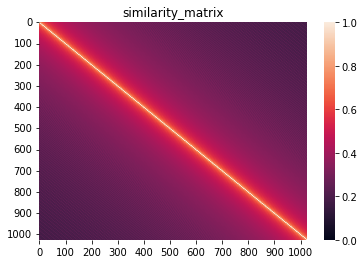

In [74]:
pos_emb = model.decoder.embed_positions.weights.cpu().detach()
cos = nn.CosineSimilarity(dim=0)
n = pos_emb.size(0)
similarity_m = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        cs = cos(pos_emb[i], pos_emb[j])
        similarity_m[i][j] = similarity_m[j][i] = cs
sns.heatmap(similarity_m, xticklabels=100, yticklabels=100)


In [71]:
# use wandb to record gnorm
# https://wandb.ai/weiweichi/hw5.seq2seq/reports/Shared-panel-22-04-06-03-04-04--VmlldzoxNzk0MzQ0?accessToken=mwlfuganu5gl0bk4saqkru69kxvt5wxac2gymbqqxkzd4uwjij56sj1y8qmk6rlx